In [96]:
# Import Python built-in libraries
import copy
import pickle
import random

In [130]:
# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

In [131]:
# Load and have a peek into the dataset
events = pd.read_csv('events.csv')
print(events.head())
print(f'There are {len(events)} rows in the raw data.')

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN
There are 2756101 rows in the raw data.


In [132]:
# Print the summarized statistics of the dataset
events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [133]:
# Check the maximum unique id of items.
# 
max(events['itemid'])

466867

In [134]:
# Filter only the 'view' events.
view_events = events[events['event'] == 'view']
print(f'There are {len(view_events)} `view` events in the raw data.')

There are 2664312 `view` events in the raw data.


In [135]:
# Filter out visitors with single clicks.
visits_per_visitor = view_events['visitorid'].value_counts(dropna=False)
visits_per_visitor.head()

filtered_visits_of_visitors = visits_per_visitor[
    visits_per_visitor > 1
].index
view_events = view_events[
    view_events['visitorid'].isin(filtered_visits_of_visitors)]

In [ ]:
# Let's group events and their timing data.
visits_data = {}
for _, row in enumerate(tqdm(view_events.iterrows())):
    timestamp, visitorid, event, itemid, transactionid = row[1].values

    if visitorid not in visits_data:
        visits_data[visitorid] = {'itemids': [], 'timestamps': []}
    visits_data[visitorid]['itemids'].append(itemid)
    visits_data[visitorid]['timestamps'].append(timestamp)

print()
print(f'There are {len(visits_data)} visitors left.')

44714it [00:01, 55863.70it/s]

In [104]:
# We will separate sessions by 1 hr.
session_gap = 1 * 3600 * 1000

# Let's group events from visitors into sessions.
sessions_of_visitors = {}
for visitorid, visitor_dict in visits_data.items():
    sessions = [[]]
    sorted_events = sorted(zip(visitor_dict['timestamps'],
                               visitor_dict['itemids']))
    for i in range(len(sorted_events) - 1):
        sessions[-1].append(sorted_events[i][1])
        if (sorted_events[i+1][0] - sorted_events[i][0]) > session_gap:
            sessions.append([])
    sessions[-1].append(sorted_events[len(sorted_events) - 1][1])
    sessions_of_visitors[visitorid] = sessions

print()
print(f'There are {len(sessions_of_visitors)} sessions.')


There are 396449 sessions.


In [105]:
# Adjsut sampling rate ([0, 1]) to generate smaller datasets.
# Setting `sampling_rate` to 1 will lead to a full dataset split.
sampling_rate = 0.5

# We use random seed for reproducibility.
seed = 42
all_visitors = list(sessions_of_visitors.keys())
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

In [128]:
def extract_subsessions(sessions):
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [129]:
# Check the number of visitors in each split
print(f'train, val, and test visitors: {len(train_visitors), len(val_visitors), len(test_visitors)}')

train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))

train, val, and test visitors: (158579, 19822, 19822)


NameError: name 'sessions_of_visitors' is not defined

In [108]:
# Check the number of (sub)sessions in each split
print(f'train, val, and test sessions: {len(train_sessions), len(val_sessions), len(test_sessions)}')

# Save the processed files.
with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

train, val, and test sessions: (373755, 49563, 52584)


In [109]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor(np.array([senders, receivers]))
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [110]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    # forward() function will contain following two things
              ## 1. Message propagation to create and use an adjacency matrix (self.propagate).
              ## 2. The GRU cell (self.gru)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    # the `message_and_aggregate()` function will simply multiply our adjacency matrix with the node embeddings
    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [111]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        # use message-passing class inside the SRGNN class
        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0) 
        embedding = self.embedding(x).squeeze()

        # (1)-(5) 
        v_i = self.gated(embedding, edge_index)

        # Divide nodes by session
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6) creating global Embedding : The global embedding is the weighted average of the embeddings of the items in the session. 
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7) The final hybrid embedding of a session is created by first concatenating the local and global embeddings
        s_l = v_n # local Embedding
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        # (8) The final scores of each item are computed by computing the cosine similarity between the session embedding (1 x d) 
        # and the embeddings of all 466867 unique items (466867 x d)
        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

In [112]:
import torch
print(torch.__version__)
print(torch.backends.cudnn.enabled)


2.6.0+cu126
True


In [113]:
import sys
print(sys.executable)


C:\Users\USER\Desktop\ML viva\.venv\Scripts\python.exe


In [114]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch Version: 2.6.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [115]:
# Define the hyperparameters.
# Code taken from 2021 Fall CS224W Colab assignments.
args = {
    'batch_size': 128,
    'hidden_dim': 64,
    'epochs': 10,
    'l2_penalty': 0.0001,
    'weight_decay': 0.1,
    'step': 5,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object):
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [23]:
print("w")

w


In [116]:
def train(args):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    device = torch.device("cuda")

    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to(device)

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to(device)
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc = test(val_loader, model, is_validation=True)
          print(test_acc)
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
  
    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [25]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def precision_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def recall_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def mean_reciprocal_rank(predictions, labels):
    recip_ranks = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        rank = np.where(pred.argsort()[::-1] == labels[i])[0][0]
        recip_ranks.append(1.0 / (rank + 1))
    return np.mean(recip_ranks)

def ndcg_at_k(predictions, labels, k):
    def dcg(scores):
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))

    ndcg_scores = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        true_relevance = np.zeros(pred.shape)
        true_relevance[labels[i]] = 1
        ranked_relevance = true_relevance[pred.argsort()[::-1]]
        ideal_relevance = np.sort(true_relevance)[::-1]
        ndcg_scores.append(dcg(ranked_relevance[:k]) / dcg(ideal_relevance[:k]))
    return np.mean(ndcg_scores)

def diversity(predictions, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    unique_items = np.unique(top_k_preds)
    return len(unique_items) / (predictions.shape[0] * k)

def novelty(predictions, k, item_popularity):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    novel_items = (item_popularity[top_k_preds] == 0).sum()
    return novel_items / (predictions.shape[0] * k)

def save_checkpoint(epoch, data, filename='checkpoint.pth.tar'):
    torch.save({'epoch': epoch, 'data': data}, filename)

def test(loader, test_model, is_validation=False, save_model_preds=False, item_popularity=None, checkpoint_interval=10):
    test_model.eval()

    # Define K for metrics.
    k = 10
    correct = 0
    top_k_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    all_scores = []

    batch_count = 0

    for idx, data in enumerate(tqdm(loader)):
        try:
            data = data.to('cuda')
            with torch.no_grad():
                score = test_model(data)
                pred = score.max(dim=1)[1]
                label = data.y

            if save_model_preds:
                all_preds.extend(pred.view(-1).cpu().detach().numpy())
                all_labels.extend(label.view(-1).cpu().detach().numpy())
                all_scores.extend(score.cpu().detach().numpy())

            correct += pred.eq(label).sum().item()
            total_samples += label.size(0)

            if not is_validation:
                score = score.cpu().detach().numpy()
                for row in range(pred.size(0)):
                    top_k_pred = np.argpartition(score[row], -k)[-k:]
                    if label[row].item() in top_k_pred:
                        top_k_correct += 1

            # Save checkpoint
            if save_model_preds and (idx + 1) % checkpoint_interval == 0:
                save_checkpoint(idx + 1, {
                    'pred': all_preds,
                    'label': all_labels,
                    'score': all_scores
                })
                # Clear intermediate results to free up memory
                all_preds = []
                all_labels = []
                all_scores = []

            # Clear CUDA cache to free up memory
            torch.cuda.empty_cache()

            batch_count += 1
            if batch_count % 10 == 0:
                print(f"Processed {batch_count} batches")

        except Exception as e:
            print(f"Error processing batch: {e}")
            torch.cuda.empty_cache()

    if save_model_preds:
        data = {
            'pred': all_preds,
            'label': all_labels,
            'score': all_scores
        }
        df = pd.DataFrame(data=data)
        df.to_csv('pred.csv', sep=',', index=False)

    if not is_validation:
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        precision_k = precision_at_k(all_scores, all_labels, k)
        recall_k = recall_at_k(all_scores, all_labels, k)
        mrr = mean_reciprocal_rank(all_scores, all_labels)
        ndcg_k = ndcg_at_k(all_scores, all_labels, k)
        diversity_score = diversity(all_scores, k)
        novelty_score = novelty(all_scores, k, item_popularity) if item_popularity is not None else 0

        return {
            'hit_rate': correct / total_samples,
            'hit_rate@k': top_k_correct / total_samples,
            'precision@k': precision_k,
            'recall@k': recall_k,
            'mrr': mrr,
            'ndcg@k': ndcg_k,
            'diversity': diversity_score,
            'novelty': novelty_score
        }
    else:
        return correct / total_samples, 0

# Run test for our best model to save the predictions!
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size // 10,  # Further reduce batch size
                                  shuffle=False,
                                  drop_last=True)

# Assuming item_popularity is a numpy array with the popularity of each item
item_popularity = np.zeros((args.num_items,))

metrics = test(test_loader, best_model, is_validation=False, save_model_preds=True, item_popularity=item_popularity)
print(metrics)

  1%|█▊                                                                                                                     | 11/747 [00:02<05:31,  2.22it/s]

Processed 10 batches


  3%|███▎                                                                                                                   | 21/747 [00:05<05:15,  2.30it/s]

Processed 20 batches


  4%|████▉                                                                                                                  | 31/747 [00:08<04:56,  2.41it/s]

Processed 30 batches


  5%|██████▌                                                                                                                | 41/747 [00:11<05:39,  2.08it/s]

Processed 40 batches


  7%|████████                                                                                                               | 51/747 [00:13<04:57,  2.34it/s]

Processed 50 batches


  8%|█████████▋                                                                                                             | 61/747 [00:16<04:45,  2.40it/s]

Processed 60 batches


 10%|███████████▎                                                                                                           | 71/747 [00:19<04:56,  2.28it/s]

Processed 70 batches


 11%|████████████▉                                                                                                          | 81/747 [00:21<04:36,  2.41it/s]

Processed 80 batches


 12%|██████████████▍                                                                                                        | 91/747 [00:24<04:53,  2.24it/s]

Processed 90 batches


 14%|███████████████▉                                                                                                      | 101/747 [00:27<04:32,  2.37it/s]

Processed 100 batches


 15%|█████████████████▌                                                                                                    | 111/747 [00:29<04:29,  2.36it/s]

Processed 110 batches


 16%|███████████████████                                                                                                   | 121/747 [00:32<04:23,  2.38it/s]

Processed 120 batches


 18%|████████████████████▋                                                                                                 | 131/747 [00:35<04:23,  2.34it/s]

Processed 130 batches


 19%|██████████████████████▎                                                                                               | 141/747 [00:37<03:43,  2.71it/s]

Processed 140 batches


 20%|███████████████████████▊                                                                                              | 151/747 [00:40<04:45,  2.09it/s]

Processed 150 batches


 22%|█████████████████████████▍                                                                                            | 161/747 [00:43<03:39,  2.67it/s]

Processed 160 batches


 23%|███████████████████████████                                                                                           | 171/747 [00:46<04:09,  2.31it/s]

Processed 170 batches


 24%|████████████████████████████▌                                                                                         | 181/747 [00:48<04:00,  2.36it/s]

Processed 180 batches


 26%|██████████████████████████████▏                                                                                       | 191/747 [00:51<03:36,  2.57it/s]

Processed 190 batches


 27%|███████████████████████████████▊                                                                                      | 201/747 [00:54<03:44,  2.43it/s]

Processed 200 batches


 28%|█████████████████████████████████▎                                                                                    | 211/747 [00:56<03:45,  2.38it/s]

Processed 210 batches


 30%|██████████████████████████████████▉                                                                                   | 221/747 [00:59<03:48,  2.31it/s]

Processed 220 batches


 31%|████████████████████████████████████▍                                                                                 | 231/747 [01:01<03:13,  2.66it/s]

Processed 230 batches


 32%|██████████████████████████████████████                                                                                | 241/747 [01:04<03:44,  2.25it/s]

Processed 240 batches


 34%|███████████████████████████████████████▋                                                                              | 251/747 [01:07<03:16,  2.53it/s]

Processed 250 batches


 35%|█████████████████████████████████████████▍                                                                            | 262/747 [01:10<02:52,  2.81it/s]

Processed 260 batches


 36%|██████████████████████████████████████████▊                                                                           | 271/747 [01:12<03:11,  2.48it/s]

Processed 270 batches


 38%|████████████████████████████████████████████▍                                                                         | 281/747 [01:15<03:28,  2.24it/s]

Processed 280 batches


 39%|█████████████████████████████████████████████▉                                                                        | 291/747 [01:18<03:17,  2.31it/s]

Processed 290 batches


 40%|███████████████████████████████████████████████▌                                                                      | 301/747 [01:20<03:09,  2.35it/s]

Processed 300 batches


 42%|█████████████████████████████████████████████████▏                                                                    | 311/747 [01:23<02:46,  2.62it/s]

Processed 310 batches


 43%|██████████████████████████████████████████████████▋                                                                   | 321/747 [01:26<03:13,  2.20it/s]

Processed 320 batches


 44%|████████████████████████████████████████████████████▎                                                                 | 331/747 [01:29<02:56,  2.35it/s]

Processed 330 batches


 46%|█████████████████████████████████████████████████████▊                                                                | 341/747 [01:31<02:37,  2.58it/s]

Processed 340 batches


 47%|███████████████████████████████████████████████████████▍                                                              | 351/747 [01:34<02:29,  2.65it/s]

Processed 350 batches


 48%|█████████████████████████████████████████████████████████                                                             | 361/747 [01:36<02:38,  2.43it/s]

Processed 360 batches


 50%|██████████████████████████████████████████████████████████▌                                                           | 371/747 [01:39<02:36,  2.40it/s]

Processed 370 batches


 51%|████████████████████████████████████████████████████████████▏                                                         | 381/747 [01:41<02:28,  2.47it/s]

Processed 380 batches


 52%|█████████████████████████████████████████████████████████████▊                                                        | 391/747 [01:44<02:28,  2.40it/s]

Processed 390 batches


 54%|███████████████████████████████████████████████████████████████▎                                                      | 401/747 [01:47<02:09,  2.68it/s]

Processed 400 batches


 55%|████████████████████████████████████████████████████████████████▉                                                     | 411/747 [01:49<02:01,  2.76it/s]

Processed 410 batches


 56%|██████████████████████████████████████████████████████████████████▌                                                   | 421/747 [01:52<02:18,  2.35it/s]

Processed 420 batches


 58%|████████████████████████████████████████████████████████████████████                                                  | 431/747 [01:55<02:07,  2.49it/s]

Processed 430 batches


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 441/747 [01:57<02:12,  2.30it/s]

Processed 440 batches


 60%|███████████████████████████████████████████████████████████████████████▏                                              | 451/747 [02:00<02:03,  2.40it/s]

Processed 450 batches


 62%|████████████████████████████████████████████████████████████████████████▊                                             | 461/747 [02:02<01:58,  2.42it/s]

Processed 460 batches


 63%|██████████████████████████████████████████████████████████████████████████▍                                           | 471/747 [02:05<01:54,  2.41it/s]

Processed 470 batches


 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 481/747 [02:08<01:54,  2.33it/s]

Processed 480 batches


 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 491/747 [02:10<01:32,  2.76it/s]

Processed 490 batches


 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 501/747 [02:13<01:39,  2.48it/s]

Processed 500 batches


 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 511/747 [02:16<01:43,  2.27it/s]

Processed 510 batches


 70%|██████████████████████████████████████████████████████████████████████████████████▎                                   | 521/747 [02:19<01:34,  2.39it/s]

Processed 520 batches


 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 530/747 [02:21<02:10,  1.66it/s]

Processed 530 batches


 72%|█████████████████████████████████████████████████████████████████████████████████████▍                                | 541/747 [02:24<01:26,  2.37it/s]

Processed 540 batches


 74%|███████████████████████████████████████████████████████████████████████████████████████                               | 551/747 [02:27<01:27,  2.24it/s]

Processed 550 batches


 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 561/747 [02:29<01:12,  2.57it/s]

Processed 560 batches


 76%|██████████████████████████████████████████████████████████████████████████████████████████▏                           | 571/747 [02:32<01:25,  2.06it/s]

Processed 570 batches


 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                          | 581/747 [02:35<01:15,  2.20it/s]

Processed 580 batches


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▎                        | 591/747 [02:38<01:11,  2.18it/s]

Processed 590 batches


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                       | 600/747 [02:41<01:07,  2.19it/s]

Processed 600 batches


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 611/747 [02:43<00:46,  2.95it/s]

Processed 610 batches


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████                    | 621/747 [02:46<00:52,  2.38it/s]

Processed 620 batches


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 631/747 [02:49<00:49,  2.34it/s]

Processed 630 batches


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 641/747 [02:51<00:46,  2.29it/s]

Processed 640 batches


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 650/747 [02:54<00:53,  1.82it/s]

Processed 650 batches


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 661/747 [02:57<00:36,  2.35it/s]

Processed 660 batches


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 670/747 [02:59<00:45,  1.69it/s]

Processed 670 batches


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 681/747 [03:02<00:26,  2.53it/s]

Processed 680 batches


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 691/747 [03:05<00:23,  2.36it/s]

Processed 690 batches


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 701/747 [03:07<00:17,  2.60it/s]

Processed 700 batches


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 711/747 [03:10<00:15,  2.27it/s]

Processed 710 batches


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 721/747 [03:13<00:11,  2.35it/s]

Processed 720 batches


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 731/747 [03:15<00:06,  2.60it/s]

Processed 730 batches


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 741/747 [03:18<00:02,  2.30it/s]

Processed 740 batches


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [03:19<00:00,  3.75it/s]


{'hit_rate': 0.250892458723784, 'hit_rate@k': 0.5554439982150825, 'precision@k': 0.6428571428571429, 'recall@k': 0.6428571428571429, 'mrr': 0.38575762477770986, 'ndcg@k': 0.4410254088639926, 'diversity': 0.41785714285714287, 'novelty': 1.0}


In [117]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 10
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to('cuda')
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('pred.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

        # We calculate Hit@K accuracy only at test time.
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1
    
    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

C:\Users\USER\Desktop\ML viva\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:09<00:00, 40.86it/s]


13.958656330749355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:07<00:00, 54.66it/s]


13.62532299741602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:07<00:00, 53.95it/s]


15.167958656330748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:07<00:00, 54.38it/s]


16.046511627906977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 57.21it/s]


16.705426356589147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 57.06it/s]


18.839793281653748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 56.23it/s]


19.20671834625323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:07<00:00, 55.12it/s]


19.51421188630491


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 56.17it/s]


19.785529715762273


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 387/387 [00:06<00:00, 58.32it/s]


19.987080103359173
[13.958656330749355, 13.62532299741602, 15.167958656330748, 16.046511627906977, 16.705426356589147, 18.839793281653748, 19.20671834625323, 19.51421188630491, 19.785529715762273, 19.987080103359173] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum test set accuracy: 19.987080103359173
Minimum loss: 5.800257827177636


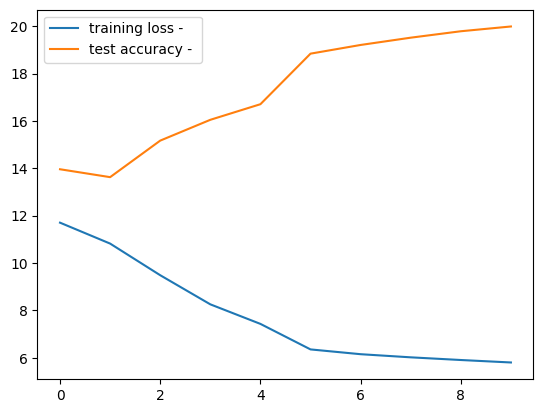

In [26]:
test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args) 

print(test_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.show()

## Model Evaluation

In [23]:
print("hi")

hi


In [10]:
print("hiiii0")

hiiii0


In [24]:
# Save the best model
torch.save(best_model.state_dict(), 'model')

In [119]:
# Run test for our best model to save the predictions!
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(test_loader, best_model, is_validation=False, save_model_preds=True)

C:\Users\USER\Desktop\ML viva\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 70/70 [01:26<00:00,  1.23s/it]


(32.128571428571426, 71.11428571428571)

In [118]:
import torch
import torch.nn as nn

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = model = SRGNN(args.hidden_dim, args.num_items).to(device)

# Load the state dictionary into the model
best_model.load_state_dict(torch.load('model', map_location=device))

# Set the model to evaluation mode
best_model.eval()

# If you're using CUDA
#best_model.to('cuda')

SRGNN(
  (embedding): Embedding(466868, 64)
  (gated): GatedSessionGraphConv()
  (q): Linear(in_features=64, out_features=1, bias=True)
  (W_1): Linear(in_features=64, out_features=64, bias=False)
  (W_2): Linear(in_features=64, out_features=64, bias=True)
  (W_3): Linear(in_features=128, out_features=64, bias=False)
)

In [1]:
import pickle
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the preprocessed data
with open('raw/train.txt', 'rb') as f:
    train_sessions = pickle.load(f)
with open('raw/val.txt', 'rb') as f:
    val_sessions = pickle.load(f)
with open('raw/test.txt', 'rb') as f:
    test_sessions = pickle.load(f)

# Combine all sessions
all_sessions = train_sessions + val_sessions + test_sessions

def generate_recommendations(visitor_id, sessions, model, top_k=10):
    # Filter sessions for the given visitor ID
    user_sessions = [session for session in sessions if session[0] == visitor_id]
    if not user_sessions:
        return "No sessions found for the given visitor ID."

    # Generate recommendations using the model
    recommendations = []
    for session in user_sessions:
        if len(session) < 2:
            continue  # Ensure session has enough elements
        session_data = np.array(session[1:])  # Convert to NumPy array for factorization

        # Build Data instance
        codes, uniques = pd.factorize(session_data)
        senders, receivers = codes[:-1], codes[1:]
        if len(senders) == 0 or len(receivers) == 0:
            continue  # Skip if there are no edges

        edge_index = torch.tensor(np.array([senders, receivers]), dtype=torch.long).to(device)
        x = torch.tensor(codes, dtype=torch.long).unsqueeze(1).to(device)
        batch = torch.zeros(len(codes), dtype=torch.long).to(device)

        data = Data(x=x, edge_index=edge_index, batch=batch)

        with torch.no_grad():
            output = model(data)
            if output.numel() < top_k:
                top_k = output.numel()  # Adjust top_k if not enough predictions
            top_items = torch.topk(output.squeeze(), top_k).indices.tolist()
            recommendations.extend(top_items)

    # Flatten and get unique recommendations
    unique_recommendations = list(set(recommendations))
    return unique_recommendations[:top_k]

# Example usage
visitor_id = 1234
recommendations = generate_recommendations(visitor_id, all_sessions, best_model, top_k=5)
print("Top 10 Recommended Items:", recommendations)

NameError: name 'best_model' is not defined